<a href="https://colab.research.google.com/github/ibrayoubi10/TER-ALLERGIE/blob/main/Data_Vis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Sickit learn met régulièrement à jour des versions et
#indique des futurs warnings.
#ces deux lignes permettent de ne pas les afficher.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# librairies générales
import pandas as pd
import re
from tabulate import tabulate
import time
import numpy as np
import pickle
import string
import base64
import sys
# librairie affichage
import matplotlib.pyplot as plt
import seaborn as sns
# librairies scikit learn
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
# librairies des classifiers utilisés
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
# librairies NLTK
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
# pour monter son drive Google Drive local
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
my_local_drive='/content/gdrive/My Drive/Colab Notebooks/TER'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive
%pwd

/content/gdrive/My Drive/Colab Notebooks/TER


'/content/gdrive/My Drive/Colab Notebooks/TER'

In [4]:
import sys
sys.path.append("/content/gdrive/My Drive/Colab Notebooks/projet_ML")
from MyNLPUtilities import *

In [5]:
import pandas as pd

# Read the Excel file
df = pd.read_excel("all_data.xlsx", engine="openpyxl")

# Display the first few rows
print(df.head())

  Patient_ID Chip_Code Chip_Type Chip_Image_Name   Age Gender  \
0    XPW0001   XPW0001   ISAC_V1             NaN  32.0      M   
1    XPW0002   XPW0002   ISAC_V1             NaN  67.0      M   
2    XPW0003   XPW0003   ISAC_V1             NaN  40.0      M   
3    XPW0004   XPW0004   ISAC_V1             NaN  57.0      F   
4    XPW0005   XPW0005   ISAC_V1             NaN  52.0      F   

   Blood_Month_sample  French_Residence_Department  French_Region  \
0                 3.0                           31             11   
1                 3.0                           11             11   
2                 3.0                           47             10   
3                 3.0                           32             11   
4                 3.0                           31             11   

   Rural_or_urban_area  ...  Tyr_p_2  Ulm_c  Urt_d  Vac_m  Ves_v  Ves_v_1  \
0                    1  ...      NaN    NaN    NaN    NaN    NaN      NaN   
1                    1  ...      NaN    

In [6]:
# Filtrer les lignes où Chip_type == "ISAC_V1"
V1_df = df[df["Chip_Type"] == "ISAC_V1"]

#extraire to an excel sheet
V1_df.to_excel("V1.xlsx", index=False)

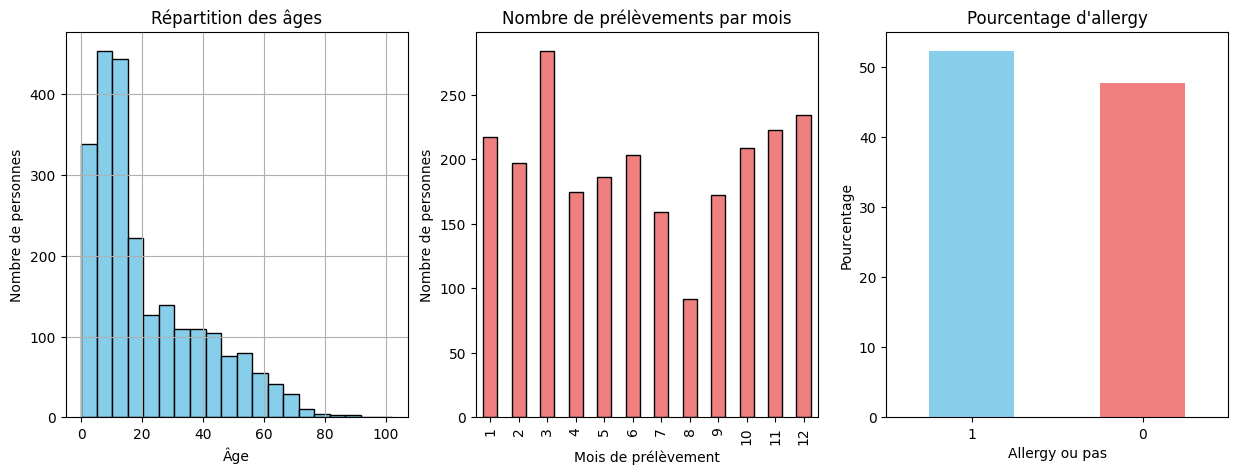

<Figure size 640x480 with 0 Axes>

In [7]:
# Définir la taille des graphiques
plt.figure(figsize=(15, 5))

# Histogramme du nombre de personnes par âge
plt.subplot(1, 3, 1)
V1_df["Age"].dropna().astype(int).hist(bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Âge")
plt.ylabel("Nombre de personnes")
plt.title("Répartition des âges")

# Nombre de personnes par mois de prélèvement sanguin
plt.subplot(1, 3, 2)
V1_df["Blood_Month_sample"].dropna().astype(int).value_counts().sort_index().plot(kind="bar", color='lightcoral', edgecolor='black')
plt.xlabel("Mois de prélèvement")
plt.ylabel("Nombre de personnes")
plt.title("Nombre de prélèvements par mois")

# Calcul du pourcentage des hommes et des femmes
allergy_counts = V1_df['Allergy_Present'].value_counts(normalize=True) * 100

# Dessiner l'histogramme
plt.subplot(1, 3, 3)
allergy_counts.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title("Pourcentage d'allergy")
plt.xlabel("Allergy ou pas")
plt.ylabel("Pourcentage")
plt.xticks(rotation=0)
plt.show()

# Afficher les graphiques
plt.tight_layout()
plt.show()

In [8]:
# Colonnes à conserver en plus des données entre "Act_d_1" et "Ves_v_5"
extra_columns = ["Patient_ID", "Chip_Code", "Allergy_Present"]

# Trouver les indices des colonnes "Act_d_1" et "Ves_v_5"
start_col = V1_df.columns.get_loc("Act_d_1")
end_col = V1_df.columns.get_loc("Ves_v_5")

# Sélectionner les colonnes spécifiques
selected_columns = extra_columns + list(df.columns[start_col:end_col + 1])
V1_data = V1_df[selected_columns]

# Afficher les premières lignes du nouveau dataframe
print(V1_data.head())

# Enregistrer dans un nouveau fichier si besoin
V1_data.to_excel("V1_data_filtered.xlsx", index=False, engine="openpyxl")

  Patient_ID Chip_Code  Allergy_Present  Act_d_1  Act_d_2  Act_d_5  Act_d_8  \
0    XPW0001   XPW0001                1      0.0     0.44      0.0      0.0   
1    XPW0002   XPW0002                1      0.0     0.00      0.0      0.0   
2    XPW0003   XPW0003                1      0.0     0.80      0.0      0.0   
3    XPW0004   XPW0004                1      0.0     0.00      0.0      0.0   
4    XPW0005   XPW0005                1      0.0     0.00      0.0      0.0   

   Aln_g_1  Alt_a_1  Alt_a_6  ...  Pla_l_1  Pol_d_5  Pru_p_1  Pru_p_3  \
0      0.0     8.42      0.0  ...      0.0      0.0      0.0      0.0   
1      0.0     0.00      0.0  ...      0.0      0.0      0.0      0.0   
2      0.0     0.38      0.0  ...      0.0      0.0      0.0      0.0   
3      0.0     0.00      0.0  ...      0.0      0.0      0.0      0.0   
4      0.0     0.00      0.0  ...      0.0      0.0      0.0      0.0   

   Sal_k_1  Ses_i_1  Tri_a_14  Tri_a_19.0101  Tri_a_aA_TI  Ves_v_5  
0      0.0      0

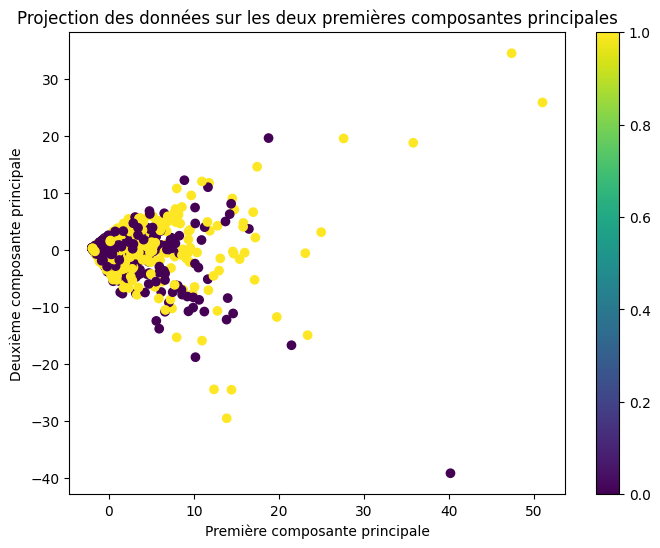

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = V1_data.drop( ["Patient_ID", "Chip_Code", "Allergy_Present"], axis=1)
y = V1_data['Allergy_Present']  # La cible (Allergy_Present)

# Standardiser les caractéristiques
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Appliquer l'ACP
pca = PCA(n_components=2)  # Réduire à 2 dimensions
X_pca = pca.fit_transform(X_scaled)

# Visualiser les résultats
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.colorbar()
plt.xlabel('Première composante principale')
plt.ylabel('Deuxième composante principale')
plt.title('Projection des données sur les deux premières composantes principales')
plt.show()

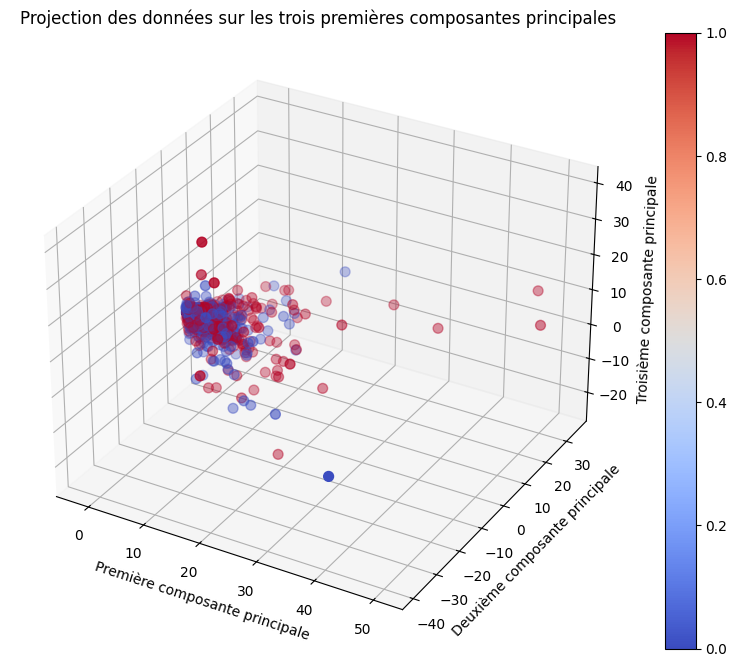

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Importer Axes3D pour la visualisation en 3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Sélectionner les caractéristiques et la cible
X = V1_data.drop(["Patient_ID", "Chip_Code", "Allergy_Present"], axis=1)
y = V1_data['Allergy_Present']  # La cible (Allergy_Present)

# Standardiser les caractéristiques
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Appliquer l'ACP
pca = PCA(n_components=3)  # Réduire à 3 dimensions
X_pca = pca.fit_transform(X_scaled)

# Visualisation en 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Créer le graphique en 3D avec une palette de couleurs différente
sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='coolwarm', s=50)

# Ajouter une barre de couleurs pour l'espèce (la cible)
plt.colorbar(sc)

# Ajouter des labels et un titre
ax.set_xlabel('Première composante principale')
ax.set_ylabel('Deuxième composante principale')
ax.set_zlabel('Troisième composante principale')
ax.set_title('Projection des données sur les trois premières composantes principales')

# Afficher le graphique
plt.show()


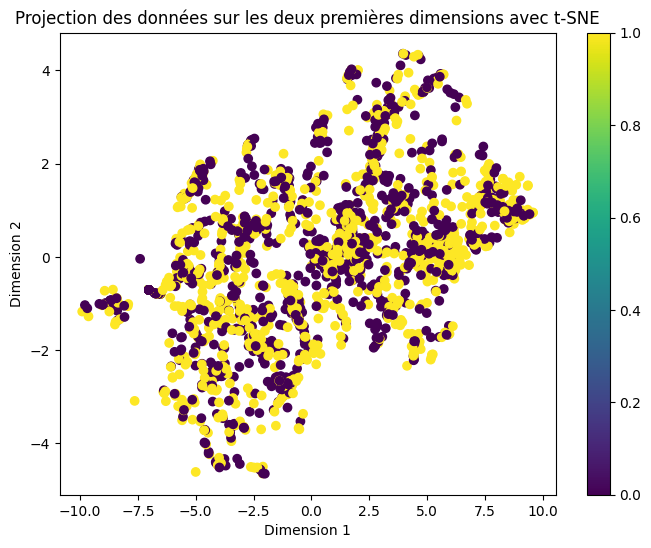

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Sélectionner les caractéristiques et la cible
X = V1_data.drop(["Patient_ID", "Chip_Code", "Allergy_Present"], axis=1)
y = V1_data['Allergy_Present']  # La cible (Allergy_Present)

# Standardiser les caractéristiques
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Appliquer t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)  # Paramètres : 2 dimensions, perplexity = 30, 300 itérations
X_tsne = tsne.fit_transform(X_scaled)

# Visualisation des résultats
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')
plt.colorbar()  # Afficher la barre de couleurs
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Projection des données sur les deux premières dimensions avec t-SNE')
plt.show()

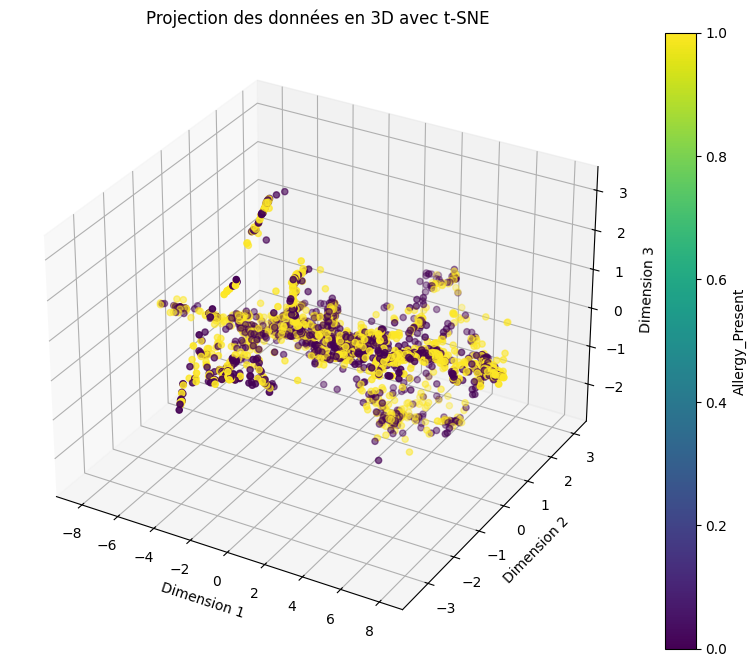

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

# Sélectionner les caractéristiques et la cible
X = V1_data.drop(["Patient_ID", "Chip_Code", "Allergy_Present"], axis=1)
y = V1_data['Allergy_Present']  # La cible (Allergy_Present)

# Standardiser les caractéristiques
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Appliquer t-SNE
tsne = TSNE(n_components=3, perplexity=30, n_iter=300)  # Paramètres : 3 dimensions, perplexity = 30, 300 itérations
X_tsne = tsne.fit_transform(X_scaled)

# Visualisation en 3D des résultats
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot 3D
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=y, cmap='viridis')

# Ajouter une barre de couleur
colorbar = plt.colorbar(scatter)
colorbar.set_label('Allergy_Present')

# Ajouter des labels aux axes
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.set_title('Projection des données en 3D avec t-SNE')

# Afficher la visualisation
plt.show()


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


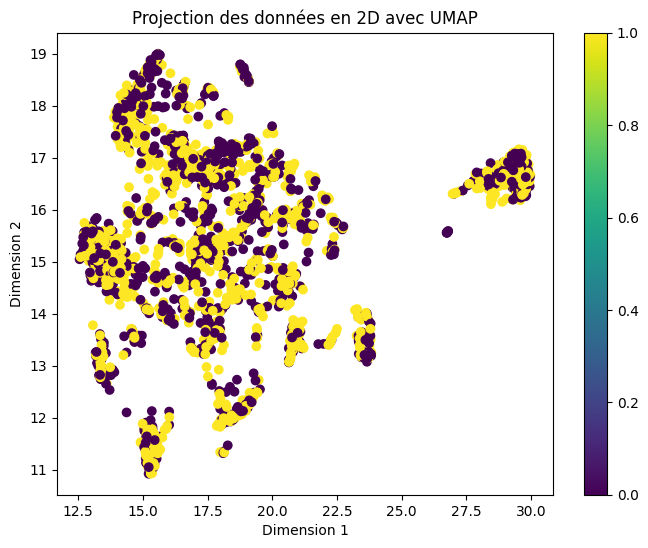

In [27]:
import umap


# Sélectionner les caractéristiques et la cible
X = V1_data.drop(["Patient_ID", "Chip_Code", "Allergy_Present"], axis=1)
y = V1_data['Allergy_Present']  # La cible (Allergy_Present)

# Standardiser les caractéristiques
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Appliquer UMAP en 2D
umap_model = umap.UMAP(n_components=2, random_state=0)
X_umap = umap_model.fit_transform(X_scaled)

# Visualisation des résultats en 2D
plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='viridis')
plt.colorbar()  # Afficher la barre de couleurs
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Projection des données en 2D avec UMAP')
plt.show()

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


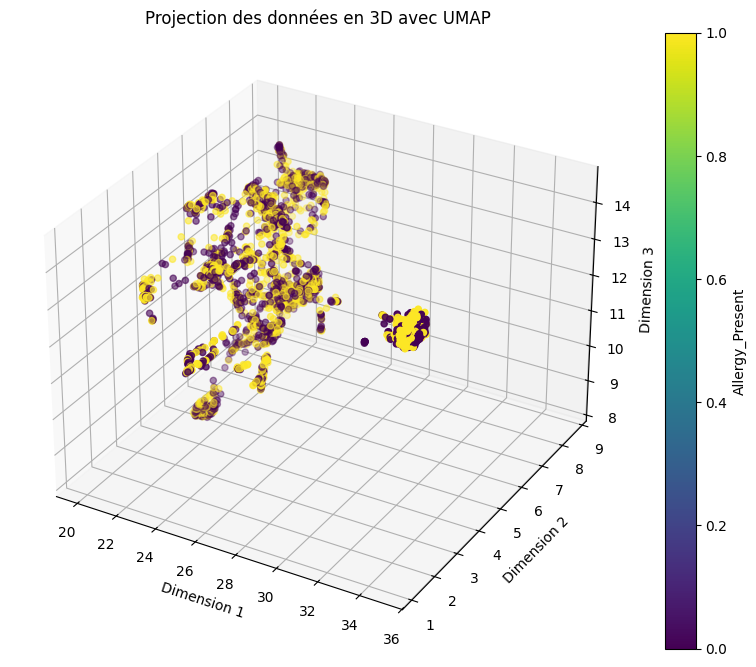

In [13]:
import umap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

# Sélectionner les caractéristiques et la cible
X = V1_data.drop(["Patient_ID", "Chip_Code", "Allergy_Present"], axis=1)
y = V1_data['Allergy_Present']  # La cible (Allergy_Present)

# Standardiser les caractéristiques
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Appliquer UMAP en 3D
umap_model_3d = umap.UMAP(n_components=3, random_state=0)
X_umap_3d = umap_model_3d.fit_transform(X_scaled)

# Visualisation des résultats en 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot 3D
scatter = ax.scatter(X_umap_3d[:, 0], X_umap_3d[:, 1], X_umap_3d[:, 2], c=y, cmap='viridis')

# Ajouter une barre de couleur
colorbar = plt.colorbar(scatter)
colorbar.set_label('Allergy_Present')

# Ajouter des labels aux axes
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.set_title('Projection des données en 3D avec UMAP')

# Afficher la visualisation
plt.show()
